In [1]:
# 경로 참조 
# /mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/04.Image_Processing/09.DOTA_crop_box_to_image.py
# data shape (n,d)
# target shape (n,)


In [1]:
import os
from glob import glob
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_f = "/mnt/hdd/eric/.tmp_ipy/00.Data/DOTA_dataset_chips/v2/images"
img_fs = os.path.join(img_f,"*.png")
img_fs_ = sorted(glob(img_fs))

ann_f = "/mnt/hdd/eric/.tmp_ipy/00.Data/DOTA_dataset_chips/v2/anns"
ann_fs = os.path.join(ann_f,"*.txt")
ann_fs_ = sorted(glob(ann_fs))

(0.0, 500.0)

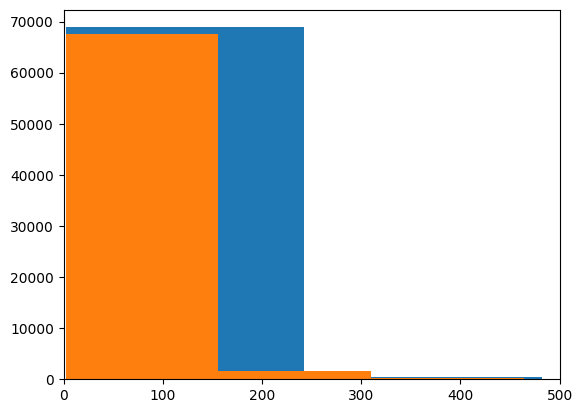

In [2]:
sizes=[]
for im in img_fs_:
    img_ = Image.open(im)
    sizes.append(img_.size)
    
xs = []
ys = []
for e in sizes:
    xs.append(e[0])
    ys.append(e[1])
    
plt.hist(xs)
plt.xlim(0,500)
plt.hist(ys)
plt.xlim(0,500)


In [3]:
# pad with an image 

import torchvision.transforms.functional as F

class Resize_with_pad:
    def __init__(self, w=300, h=300):
        self.w = w
        self.h = h

    def __call__(self, image):

        w_1, h_1 = image.size
        ratio_f = self.w / self.h
        ratio_1 = w_1 / h_1


        # check if the original and final aspect ratios are the same within a margin
        if round(ratio_1, 2) != round(ratio_f, 2):

            # padding to preserve aspect ratio
            hp = int(w_1/ratio_f - h_1)
            wp = int(ratio_f * h_1 - w_1)
            if hp > 0 and wp < 0:
                hp = hp // 2
                image = F.pad(image, (0, hp, 0, hp), 0, "constant")
                return F.resize(image, [self.h, self.w])

            elif hp < 0 and wp > 0:
                wp = wp // 2
                image = F.pad(image, (wp, 0, wp, 0), 0, "constant")
                return F.resize(image, [self.h, self.w])

        else:
            return F.resize(image, [self.h, self.w])
#--
Resize_with_pad_ = Resize_with_pad()

/mnt/hdd/eric/.conda/envs/mah_v1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sample_img = Image.open(img_fs_[0])
output_img = Resize_with_pad_(sample_img)
output = np.asarray(output_img)
print(output.shape)

(300, 300, 3)


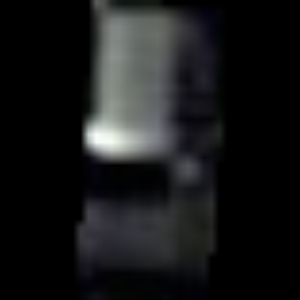

In [5]:
output_img

In [6]:
#--------------------------------------------
from tqdm import tqdm
img_ls = []
for image_path in tqdm(img_fs_):
    img = Image.open(image_path)
    output_img = Resize_with_pad_(img)
    output = np.asarray(output_img)
    img_ls.append(output)

100%|██████████| 69565/69565 [01:07<00:00, 1024.43it/s]


In [7]:
sampling_nums = 10000 

#------ sampling 
sample_dist = img_ls[0:sampling_nums]

img_flats = []
for img in sample_dist:
    img_flat = np.reshape(img,-1)
    img_flats.append(img_flat)

img_flats = np.asarray(img_flats)
print(img_flats.shape)

(10000, 270000)


In [8]:
targets =[]
for i in tqdm(range(len(ann_fs_))):
    with open(ann_fs_[i]) as file:
        single_l = file.readlines()
        target = single_l[0].split()[-2]
        targets.append(target)


100%|██████████| 69565/69565 [00:00<00:00, 75025.99it/s]


In [13]:
dict_ = set(targets)
cate_ = dict()
for i,k in enumerate(dict_) :
    cate_[k] = i  

cate_

{'bridge': 0,
 'tennis-court': 1,
 'swimming-pool': 2,
 'ship': 3,
 'storage-tank': 4,
 'roundabout': 5,
 'small-vehicle': 6,
 'ground-track-field': 7,
 'harbor': 8,
 'helicopter': 9,
 'large-vehicle': 10,
 'plane': 11,
 'basketball-court': 12,
 'baseball-diamond': 13,
 'container-crane': 14,
 'soccer-ball-field': 15}

In [14]:
targets_n = []
for t in targets:
    t_n = cate_[t]
    targets_n.append(t_n)

targets_n = np.asarray(targets_n) 
targets_n = targets_n[:sampling_nums]
targets_n.shape

(10000,)

In [15]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=3, random_state=0)

features = img_flats
projections = tsne.fit_transform(features, )

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=targets_n, labels={'color': 'category'},
    width = 800,
    height = 800
)
fig.update_traces(marker_size=8)
fig.show()

/mnt/hdd/eric/.conda/envs/mah_v1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/hdd/eric/.conda/envs/mah_v1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [16]:
from umap import UMAP
import plotly.express as px

df = px.data.iris()

#features = df.loc[:, :'petal_width']
features = img_flats

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=targets_n, labels={'color': 'target'}
)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=targets_n, labels={'color': 'target'},    width = 800,
    height = 800
)
fig_3d.update_traces(marker_size=5)

fig_2d.show()
fig_3d.show()

/mnt/hdd/eric/.conda/envs/mah_v1/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/mnt/hdd/eric/.conda/envs/mah_v1/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

